In [2]:
import terratorch
from terratorch.registry import BACKBONE_REGISTRY, DECODER_REGISTRY
from terratorch.models import EncoderDecoderFactory
import torch
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

/share/home/adorni/bench/ensemble/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
backbone = BACKBONE_REGISTRY.build(
    "timm_convnextv2_atto",
    pretrained=False,
    in_chans=6
)

decoder = DECODER_REGISTRY.build(
    "UperNetDecoder",
    channels=128,
    embed_dim=[40, 80, 160, 320],
)

model = EncoderDecoderFactory().build_model(
    task="segmentation",
    backbone=backbone,
    decoder=decoder,
    num_classes=2,
)

In [18]:
[out.shape for out in backbone(torch.randn(1, 6, 512, 512))]

[torch.Size([1, 40, 128, 128]),
 torch.Size([1, 80, 64, 64]),
 torch.Size([1, 160, 32, 32]),
 torch.Size([1, 320, 16, 16])]

In [3]:
def load_low_res(zone_path):
    folders = ["flood_label", "vh", "vv", "water_body_label"]
    
    # first pass to find out the number of patches
    max_x = 0
    max_y = 0
    for file in os.listdir(os.path.join(zone_path, folders[0])):
        if file.endswith(".png"):
            x = int(file.split("_")[2].split("-")[1].strip(".png"))
            y = int(file.split("_")[3].split("-")[1].strip(".png"))
            if x > max_x:
                max_x = x
            if y > max_y:
                max_y = y
    
    patches = [np.zeros(((max_x + 1)*16, (max_y + 1)*16, 3), dtype=np.uint8) for _ in folders]
    pbar = tqdm(total=(max_x + 1) * (max_y + 1) * len(folders), desc="Loading patches")
    for i, folder in enumerate(folders):
        for file in os.listdir(os.path.join(zone_path,folder)):
            if file.endswith(".png"):
                x = int(file.split("_")[2].split("-")[1].strip(".png"))
                y = int(file.split("_")[3].split("-")[1].strip(".png"))

                img = cv2.imread(os.path.join(zone_path, folder, file), cv2.IMREAD_UNCHANGED)
                # print(os.path.join(zone_path, folder, file))
                img = cv2.resize(img, (16, 16), interpolation=cv2.INTER_NEAREST)

                patches[i][x*16:(x+1)*16, y*16:(y+1)*16] = img
                pbar.update(1)
    pbar.close()
    return patches

In [51]:
flood_label, vh, vv, water_body_label = load_low_res("data/etci2021/train/nebraska_20170309t002110/tiles")

Loading patches: 100%|██████████| 4032/4032 [00:06<00:00, 655.33it/s] 


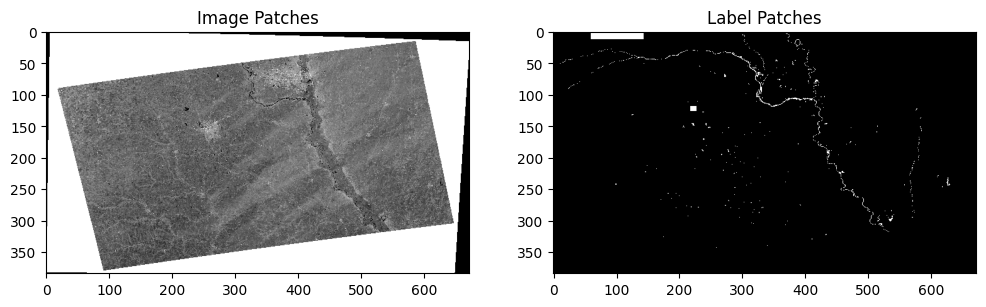

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title("Image Patches")
ax[0].imshow(vv)
ax[1].set_title("Label Patches")
ax[1].imshow(flood_label)
plt.show()

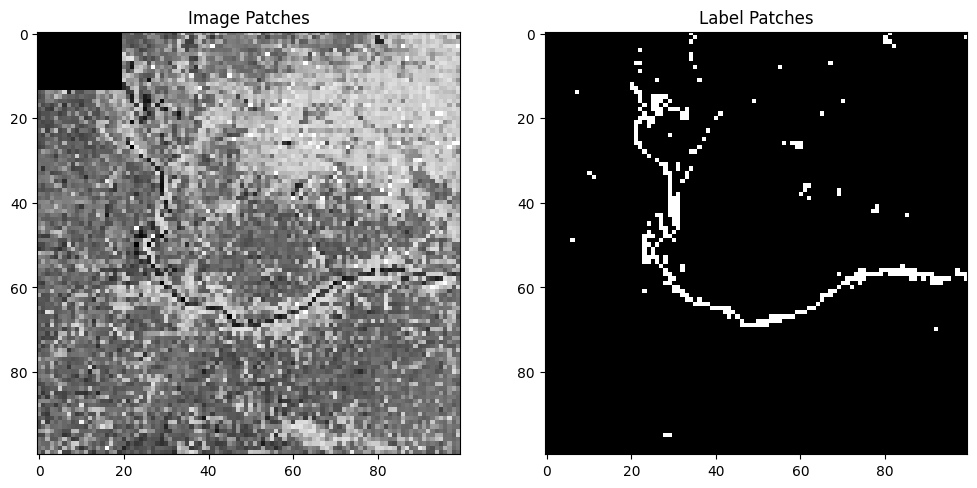

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title("Image Patches")
ax[0].imshow(vh[50:150, 300:400], cmap='gray')
ax[1].set_title("Label Patches")
ax[1].imshow(flood_label[50:150, 300:400], cmap='gray')
plt.show()

In [53]:
vv = vv[:,:, 0]
vh = vh[:,:, 0]
flood_label = flood_label[:,:, 0]
water_body_label = water_body_label[:,:, 0]

In [54]:
composite = np.zeros((vh.shape[0], vh.shape[1], 3), dtype=np.uint8)
composite[:,:,0] = vh
composite[:,:,1] = vv
composite[:,:,2] = vh
# composite[:,:,2] = flood_label

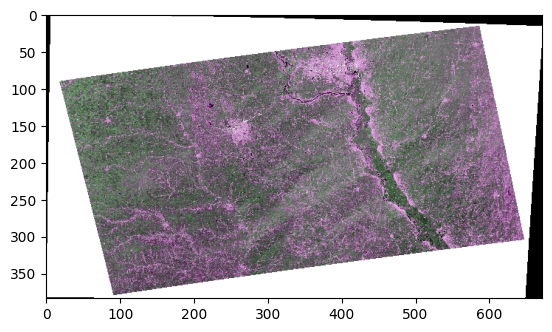

In [55]:
plt.imshow(composite)

In [59]:
def replace_nodata(img):
    nodata_mask = np.zeros(img.shape[:2], dtype=bool)
    for i in range(img.shape[0] // 16):
        for j in range(img.shape[1] // 16):
            patch = img[i*16:(i+1)*16, j*16:(j+1)*16]
            white_or_black_pixels = np.sum(patch == 255) + np.sum(patch == 0)
            total_pixels = patch.shape[0] * patch.shape[1]
            if white_or_black_pixels / total_pixels > 0.1:
                nodata_mask[i*16:(i+1)*16, j*16:(j+1)*16] = True
    return nodata_mask

nodata_mask = replace_nodata(vv)
vv = np.where(nodata_mask, 0, vv)
vh = np.where(nodata_mask, 0, vh)
flood_label = np.where(nodata_mask, 0, flood_label)
water_body_label = np.where(nodata_mask, 0, water_body_label)
composite = np.zeros((vh.shape[0], vh.shape[1], 3), dtype=np.uint8)
composite[:,:,0] = vh
composite[:,:,1] = vv
composite[:,:,2] = vh

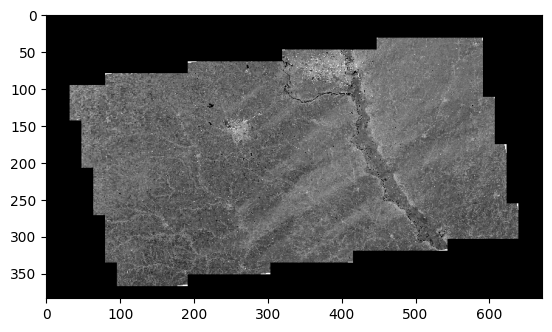

In [60]:
plt.imshow(vv, cmap='gray')

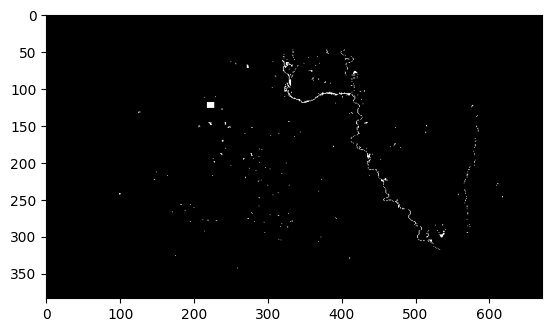

In [61]:
plt.imshow(flood_label, cmap='gray')

In [119]:
import shutil
from pathlib import Path

def identify_nodata_patches(patch_path):
    """
    Identify patches that have too many white or black pixels (nodata).
    Returns True if the patch should be removed.
    """
    try:
        img = cv2.imread(str(patch_path), cv2.IMREAD_UNCHANGED)
        if img is None:
            return True  # Remove if can't read
        img = img[:,:,0]
        white_or_black_pixels = np.sum(img == 255) + np.sum(img == 0)
        total_pixels = img.shape[0] * img.shape[1]
        
        # If more than 10% of pixels are white or black, consider it nodata
        return (white_or_black_pixels / total_pixels) > 0.1
    except Exception as e:
        print(f"Error processing {patch_path}: {e}")
        return True  # Remove if error occurs

def clean_dataset(base_path, target_path):
    """
    Clean the dataset by removing patches with too much nodata.
    This function will process both train and test splits.
    """
    base_path = Path(base_path)
    target_path = Path(target_path)
    
    folders = ["flood_label", "vh", "vv", "water_body_label"]
    splits = ["train", "test"]
    
    total_removed = 0
    total_processed = 0
    
    for split in splits:
        split_path = base_path / split
        target_split_path = target_path / split
        
        if not split_path.exists():
            continue

        # Get all location directories
        for location_dir in tqdm(split_path.iterdir(), total=len(os.listdir(split_path)) , desc=f"Processing {split} split"):
            if not location_dir.is_dir() or location_dir.name.startswith('.') or location_dir.name == '__MACOSX':
                continue
            
            tiles_path = location_dir / "tiles"
            target_tiles_path = target_split_path / location_dir.name / "tiles"
            
            if not tiles_path.exists():
                continue
            
            # Get all patches from the flood_label folder to determine coordinates
            flood_label_path = tiles_path / "flood_label"
            target_flood_label_path = target_tiles_path / "flood_label"
            
            if not flood_label_path.exists():
                continue
            
            patches_to_remove = set()
            patches_to_keep = set()

            # identify patches to remove based on nodata on vh and vv (not labels)
            for folder in ["vh", "vv"]:
                folder_path = tiles_path / folder
                if not folder_path.exists():
                    print(f"    Folder {folder} does not exist in {location_dir.name}, skipping...")
                    continue
                
                for patch_file in folder_path.iterdir():
                    if not patch_file.name.endswith('.png'):
                        print(f"    Skipping non-png file {patch_file.name} in {folder}")
                        continue
                    
                    try:
                        parts = patch_file.name.split('_')
                        x_part = parts[-3]  # x-N
                        y_part = parts[-2]  # y-N
                        # print(f"    Processing patch {patch_file.name} at coordinates ({x_part}, {y_part})")
                        
                        if identify_nodata_patches(patch_file):
                            patches_to_remove.add((x_part, y_part))
                        else:
                            patches_to_keep.add((x_part, y_part))
                            
                    except Exception as e:
                        print(f"    Error parsing filename {patch_file.name}: {e}")
                        continue
            
            # Copy patches to keep to the target directory
            if not target_tiles_path.exists():
                target_tiles_path.mkdir(parents=True, exist_ok=True)
            for folder in folders:
                target_folder_path = target_tiles_path / folder
                if not target_folder_path.exists():
                    target_folder_path.mkdir(parents=True, exist_ok=True)
                
                for patch_file in (tiles_path / folder).iterdir():
                    if not patch_file.name.endswith('.png'):
                        continue
                    
                    parts = patch_file.name.removesuffix("_vv.png").removesuffix("_vh.png").removesuffix(".png").split('_')
                    x_part = parts[-2]
                    y_part = parts[-1]
                    if (x_part, y_part) in patches_to_keep:
                        target_patch_path = target_folder_path / patch_file.name
                        shutil.copy(patch_file, target_patch_path)
                    total_processed += 1

            print(f"    Removed {len(patches_to_remove)} patch sets ({total_removed} files)")
            total_removed += len(patches_to_remove)
    
    print(f"\nCleaning complete!")
    print(f"Total patches processed: {total_processed}")
    print(f"Total patch sets removed: {total_removed}")
    print(f"Removal rate: {total_removed/total_processed*100:.2f}%")

# Test the function on a small sample first
print("Testing nodata detection function...")
sample_patch = "data/etci2021/train/nebraska_20170309t002110/tiles/vv/nebraska_20170309t002110_x-0_y-0_vv.png"
if os.path.exists(sample_patch):
    is_nodata = identify_nodata_patches(sample_patch)
    print(f"Sample patch {sample_patch} is nodata: {is_nodata}")
else:
    print(f"Sample patch {sample_patch} not found")

Testing nodata detection function...
Sample patch data/etci2021/train/nebraska_20170309t002110/tiles/vv/nebraska_20170309t002110_x-0_y-0_vv.png is nodata: True


In [120]:
# Find some actual patch files to test
test_dir = "data/etci2021/train/nebraska_20170309t002110/tiles/vv/"
test_files = os.listdir(test_dir)[:5]  # Get first 5 files
print("Available test files:", test_files)

# Test the function on actual files
for test_file in test_files[:3]:
    if test_file.endswith('.png'):
        test_path = os.path.join(test_dir, test_file)
        is_nodata = identify_nodata_patches(test_path)
        print(f"File {test_file}: is_nodata = {is_nodata}")
        
        # Also show some stats about the patch
        img = cv2.imread(test_path, cv2.IMREAD_UNCHANGED)
        img = img[:, :, 0] if img.ndim == 3 else img  # Ensure single channel
        if img is not None:
            white_pixels = np.sum(img == 255)
            black_pixels = np.sum(img == 0)
            total_pixels = img.shape[0] * img.shape[1]
            percentage = (white_pixels + black_pixels) / total_pixels * 100
            print(f"  Shape: {img.shape}, White/Black pixels: {white_pixels + black_pixels}/{total_pixels} ({percentage:.1f}%)")
        print()

Available test files: ['nebraska_20170309t002110_x-23_y-40_vv.png', 'nebraska_20170309t002110_x-19_y-35_vv.png', 'nebraska_20170309t002110_x-4_y-18_vv.png', 'nebraska_20170309t002110_x-22_y-32_vv.png', 'nebraska_20170309t002110_x-18_y-37_vv.png']
File nebraska_20170309t002110_x-23_y-40_vv.png: is_nodata = True
  Shape: (256, 256), White/Black pixels: 65536/65536 (100.0%)

File nebraska_20170309t002110_x-19_y-35_vv.png: is_nodata = True
  Shape: (256, 256), White/Black pixels: 22832/65536 (34.8%)

File nebraska_20170309t002110_x-4_y-18_vv.png: is_nodata = False
  Shape: (256, 256), White/Black pixels: 128/65536 (0.2%)



In [121]:
# Now run the cleaning process on the clean dataset
print("Starting dataset cleaning process...")
print("This may take several minutes...")

# Clean the dataset
clean_dataset("data/etci2021", "data/etci2021-clean")

Starting dataset cleaning process...
This may take several minutes...


Processing train split:   3%|▎         | 1/32 [00:08<04:18,  8.35s/it]

    Removed 398 patch sets (0 files)


Processing train split:   6%|▋         | 2/32 [00:18<04:51,  9.70s/it]

    Removed 319 patch sets (398 files)


Processing train split:   9%|▉         | 3/32 [00:29<04:46,  9.88s/it]

    Removed 320 patch sets (717 files)


Processing train split:  12%|█▎        | 4/32 [00:41<05:09, 11.06s/it]

    Removed 372 patch sets (1037 files)


Processing train split:  16%|█▌        | 5/32 [00:54<05:17, 11.75s/it]

    Removed 395 patch sets (1409 files)


Processing train split:  19%|█▉        | 6/32 [01:06<05:06, 11.80s/it]

    Removed 321 patch sets (1804 files)


Processing train split:  22%|██▏       | 7/32 [01:19<05:00, 12.01s/it]

    Removed 398 patch sets (2125 files)


Processing train split:  25%|██▌       | 8/32 [01:31<04:47, 11.97s/it]

    Removed 398 patch sets (2523 files)


Processing train split:  28%|██▊       | 9/32 [01:44<04:47, 12.51s/it]

    Removed 345 patch sets (2921 files)


Processing train split:  31%|███▏      | 10/32 [01:59<04:48, 13.13s/it]

    Removed 396 patch sets (3266 files)


Processing train split:  34%|███▍      | 11/32 [02:10<04:23, 12.56s/it]

    Removed 397 patch sets (3662 files)


Processing train split:  38%|███▊      | 12/32 [02:22<04:05, 12.29s/it]

    Removed 320 patch sets (4059 files)


Processing train split:  41%|████      | 13/32 [02:46<05:04, 16.01s/it]

    Removed 824 patch sets (4379 files)


Processing train split:  44%|████▍     | 14/32 [02:59<04:28, 14.91s/it]

    Removed 309 patch sets (5203 files)


Processing train split:  47%|████▋     | 15/32 [03:11<04:01, 14.22s/it]

    Removed 340 patch sets (5512 files)


Processing train split:  50%|█████     | 16/32 [03:36<04:38, 17.44s/it]

    Removed 895 patch sets (5852 files)


Processing train split:  53%|█████▎    | 17/32 [03:49<04:01, 16.12s/it]

    Removed 397 patch sets (6747 files)


Processing train split:  56%|█████▋    | 18/32 [04:01<03:26, 14.74s/it]

    Removed 331 patch sets (7144 files)


Processing train split:  62%|██████▎   | 20/32 [04:12<02:04, 10.41s/it]

    Removed 338 patch sets (7475 files)


Processing train split:  66%|██████▌   | 21/32 [04:22<01:55, 10.48s/it]

    Removed 396 patch sets (7813 files)


Processing train split:  69%|██████▉   | 22/32 [04:34<01:47, 10.76s/it]

    Removed 318 patch sets (8209 files)


Processing train split:  72%|███████▏  | 23/32 [04:47<01:42, 11.34s/it]

    Removed 340 patch sets (8527 files)


Processing train split:  75%|███████▌  | 24/32 [04:59<01:32, 11.60s/it]

    Removed 395 patch sets (8867 files)


Processing train split:  78%|███████▊  | 25/32 [05:12<01:24, 12.07s/it]

    Removed 335 patch sets (9262 files)


Processing train split:  81%|████████▏ | 26/32 [05:25<01:14, 12.40s/it]

    Removed 332 patch sets (9597 files)


Processing train split:  84%|████████▍ | 27/32 [05:38<01:02, 12.41s/it]

    Removed 343 patch sets (9929 files)


Processing train split:  88%|████████▊ | 28/32 [06:01<01:02, 15.59s/it]

    Removed 696 patch sets (10272 files)


Processing train split:  91%|█████████ | 29/32 [06:11<00:41, 13.86s/it]

    Removed 397 patch sets (10968 files)


Processing train split:  94%|█████████▍| 30/32 [06:22<00:26, 13.14s/it]

    Removed 326 patch sets (11365 files)


Processing train split:  97%|█████████▋| 31/32 [06:34<00:12, 12.73s/it]

    Removed 320 patch sets (11691 files)


Processing train split: 100%|██████████| 32/32 [06:48<00:00, 12.75s/it]


    Removed 498 patch sets (12011 files)


Processing test split:  10%|█         | 1/10 [00:11<01:41, 11.25s/it]

    Removed 603 patch sets (12509 files)


Processing test split:  20%|██        | 2/10 [00:20<01:21, 10.16s/it]

    Removed 616 patch sets (13112 files)


Processing test split:  30%|███       | 3/10 [00:31<01:12, 10.38s/it]

    Removed 601 patch sets (13728 files)


Processing test split:  40%|████      | 4/10 [00:42<01:03, 10.61s/it]

    Removed 612 patch sets (14329 files)


Processing test split:  50%|█████     | 5/10 [00:53<00:53, 10.76s/it]

    Removed 609 patch sets (14941 files)


Processing test split:  60%|██████    | 6/10 [01:04<00:43, 10.99s/it]

    Removed 606 patch sets (15550 files)


Processing test split:  70%|███████   | 7/10 [01:13<00:30, 10.31s/it]

    Removed 607 patch sets (16156 files)


Processing test split:  80%|████████  | 8/10 [01:23<00:20, 10.25s/it]

    Removed 610 patch sets (16763 files)


Processing test split:  90%|█████████ | 9/10 [01:34<00:10, 10.42s/it]

    Removed 607 patch sets (17373 files)


Processing test split: 100%|██████████| 10/10 [01:56<00:00, 11.69s/it]

    Removed 607 patch sets (17980 files)

Cleaning complete!
Total patches processed: 175220
Total patch sets removed: 18587
Removal rate: 10.61%


In [87]:
def clean_dataset_v2(source_path, target_path):
    """
    Clean the dataset by copying only good patches (filtering out nodata patches).
    This function will process both train and test splits.
    """
    source_path = Path(source_path)
    target_path = Path(target_path)
    
    # Remove target directory if it exists and recreate it
    if target_path.exists():
        shutil.rmtree(target_path)
    target_path.mkdir(parents=True, exist_ok=True)
    
    folders = ["flood_label", "vh", "vv", "water_body_label"]
    splits = ["train", "test"]
    
    total_patches = 0
    total_copied = 0
    total_removed = 0
    
    for split in splits:
        source_split_path = source_path / split
        target_split_path = target_path / split
        
        if not source_split_path.exists():
            continue
            
        print(f"\nProcessing {split} split...")
        target_split_path.mkdir(parents=True, exist_ok=True)
        
        # Get all location directories
        location_dirs = [d for d in source_split_path.iterdir() 
                        if d.is_dir() and not d.name.startswith('.') and d.name != '__MACOSX']
        
        for i, location_dir in enumerate(location_dirs):
            print(f"  Processing location {i+1}/{len(location_dirs)}: {location_dir.name}")
            
            source_tiles_path = location_dir / "tiles"
            target_location_path = target_split_path / location_dir.name
            target_tiles_path = target_location_path / "tiles"
            
            if not source_tiles_path.exists():
                continue
            
            # Create target directory structure
            target_location_path.mkdir(parents=True, exist_ok=True)
            target_tiles_path.mkdir(parents=True, exist_ok=True)
            
            # Create folders in target
            for folder in folders:
                (target_tiles_path / folder).mkdir(parents=True, exist_ok=True)
            
            # Get all patches from the flood_label folder to determine coordinates
            source_flood_label_path = source_tiles_path / "flood_label"
            
            if not source_flood_label_path.exists():
                continue
            
            patches_to_keep = set()
            patches_to_remove = set()
            
            # Check each patch in all folders to identify good vs bad patches
            all_patch_coords = set()
            
            # First, collect all unique patch coordinates
            for folder in folders:
                folder_path = source_tiles_path / folder
                if not folder_path.exists():
                    continue
                
                for patch_file in folder_path.iterdir():
                    if not patch_file.name.endswith('.png'):
                        continue
                    
                    try:
                        parts = patch_file.name.split('_')
                        x_part = parts[-2]  # x-N
                        y_part = parts[-1]  # y-N.png
                        all_patch_coords.add((x_part, y_part))
                    except:
                        continue
            
            print(f"    Found {len(all_patch_coords)} unique patch coordinates")
            
            # Now check each coordinate to see if we should keep it
            for x_part, y_part in all_patch_coords:
                total_patches += 1
                should_remove = False
                
                # Check each folder for this coordinate
                for folder in folders:
                    folder_path = source_tiles_path / folder
                    if not folder_path.exists():
                        continue
                    
                    # Find the patch file with these coordinates
                    matching_files = list(folder_path.glob(f"*_{x_part}_{y_part}"))
                    if not matching_files:
                        continue
                    
                    patch_file = matching_files[0]
                    if identify_nodata_patches(patch_file):
                        should_remove = True
                        break
                
                if should_remove:
                    patches_to_remove.add((x_part, y_part))
                    total_removed += 1
                else:
                    patches_to_keep.add((x_part, y_part))
                    total_copied += 1
            
            # Copy the good patches
            copied_files = 0
            for x_part, y_part in patches_to_keep:
                for folder in folders:
                    source_folder_path = source_tiles_path / folder
                    target_folder_path = target_tiles_path / folder
                    
                    if not source_folder_path.exists():
                        continue
                    
                    # Find and copy the patch file
                    matching_files = list(source_folder_path.glob(f"*_{x_part}_{y_part}"))
                    for patch_file in matching_files:
                        target_file = target_folder_path / patch_file.name
                        try:
                            shutil.copy2(patch_file, target_file)
                            copied_files += 1
                        except Exception as e:
                            print(f"    Error copying {patch_file}: {e}")
            
            print(f"    Kept {len(patches_to_keep)} patches, removed {len(patches_to_remove)} patches")
            print(f"    Copied {copied_files} files")
    
    print(f"\nCleaning complete!")
    print(f"Total unique patches found: {total_patches}")
    print(f"Total patches kept: {total_copied}")
    print(f"Total patches removed: {total_removed}")
    print(f"Removal rate: {total_removed/total_patches*100:.2f}%")

# Test on a small subset first
print("Starting improved dataset cleaning process...")
print("This will copy good patches and skip bad ones...")

Starting improved dataset cleaning process...
This will copy good patches and skip bad ones...


In [88]:
# Run the improved cleaning function
clean_dataset_v2("data/etci2021", "data/etci2021-clean")


Processing train split...
  Processing location 1/31: nebraska_20170213t002121
    Found 1092 unique patch coordinates
    Kept 49 patches, removed 1043 patches
    Copied 1176 files
  Processing location 2/31: northal_20191004t234700
    Found 1014 unique patch coordinates
    Kept 49 patches, removed 965 patches
    Copied 1176 files
  Processing location 3/31: northal_20190724t234657
    Found 1014 unique patch coordinates
    Kept 49 patches, removed 965 patches
    Copied 1176 files
  Processing location 4/31: nebraska_20170108t002112
    Found 1066 unique patch coordinates
    Kept 49 patches, removed 1017 patches
    Copied 1176 files
  Processing location 5/31: nebraska_20171222t002118
    Found 1092 unique patch coordinates
    Kept 48 patches, removed 1044 patches
    Copied 1152 files
  Processing location 6/31: northal_20190618t234654
    Found 1014 unique patch coordinates
    Kept 43 patches, removed 971 patches
    Copied 1032 files
  Processing location 7/31: nebraska_

In [89]:
# Let's verify the cleaning results by comparing file counts
def count_files_in_dataset(dataset_path):
    """Count total number of .png files in the dataset"""
    dataset_path = Path(dataset_path)
    total_files = 0
    
    for png_file in dataset_path.glob("**/*.png"):
        total_files += 1
    
    return total_files

original_count = count_files_in_dataset("data/etci2021")
cleaned_count = count_files_in_dataset("data/etci2021-clean")

print(f"Original dataset (etci2021): {original_count} PNG files")
print(f"Cleaned dataset (etci2021-clean): {cleaned_count} PNG files")
print(f"Files removed: {original_count - cleaned_count}")
print(f"Removal rate: {(original_count - cleaned_count) / original_count * 100:.2f}%")

Original dataset (etci2021): 350448 PNG files
Cleaned dataset (etci2021-clean): 49238 PNG files
Files removed: 301210
Removal rate: 85.95%
